# 05 - Unsupervised Learning & Clustering
## Heart Disease UCI Dataset

### Objectives:
- Apply K-Means clustering to discover natural patient groups
- Perform Hierarchical Clustering with dendrogram analysis
- Compare clustering results with actual disease labels
- Evaluate clustering quality using internal metrics
- Visualize clusters in 2D and 3D space

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    silhouette_score, calinski_harabasz_score, davies_bouldin_score,
    adjusted_rand_score, normalized_mutual_info_score
)
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print(" Libraries imported successfully!")

 Libraries imported successfully!


## 2. Load and Prepare Data for Clustering

In [2]:
def load_data_for_clustering():
    """Load data for unsupervised learning"""
    try:
        # Load the full processed dataset
        df = pd.read_csv('../data/heart_disease_processed.csv')
        
        # Separate features and target
        X = df.drop(['target', 'source'], axis=1)
        y = df['target']
        
        print(" Loaded processed dataset for clustering")
        
    except FileNotFoundError:
        print(" Processed dataset not found! Running data preprocessing...")
        
        # If preprocessing hasn't been done, load raw data and preprocess
        try:
            df = pd.read_csv('../data/heart_disease.csv')
            
            # Basic preprocessing
            from sklearn.preprocessing import StandardScaler
            
            # Handle missing values
            df.fillna(df.median(numeric_only=True), inplace=True)
            
            # Separate features and target
            X = df.drop(['target', 'source'], axis=1, errors='ignore')
            if 'source' not in df.columns:
                X = df.drop(['target'], axis=1)
            y = df['target']
            
            # Scale features
            scaler = StandardScaler()
            X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
            
            print(" Preprocessed data for clustering")
            
        except FileNotFoundError:
            print(" No dataset found! Please run data consolidation first.")
            return None, None
    
    return X, y

# Load data
X, y_true = load_data_for_clustering()

if X is not None:
    print(f"\n Dataset Summary:")
    print(f"   Features: {X.shape[1]}")
    print(f"   Samples: {X.shape[0]}")
    print(f"   Feature names: {list(X.columns)}")
    
    if y_true is not None:
        print(f"   True labels available: Yes")
        print(f"   True classes: {sorted(y_true.unique())}")
        print(f"   Class distribution:")
        for class_val in sorted(y_true.unique()):
            count = (y_true == class_val).sum()
            print(f"     Class {class_val}: {count} samples ({count/len(y_true)*100:.1f}%)")
    else:
        print(f"   True labels available: No")

# Display first few rows
if X is not None:
    X.head()

 Loaded processed dataset for clustering

 Dataset Summary:
   Features: 13
   Samples: 920
   Feature names: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
   True labels available: Yes
   True classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
   Class distribution:
     Class 0: 411 samples (44.7%)
     Class 1: 265 samples (28.8%)
     Class 2: 109 samples (11.8%)
     Class 3: 107 samples (11.6%)
     Class 4: 28 samples (3.0%)


## 3. Dimensionality Reduction for Visualization

In [3]:
print("=== DIMENSIONALITY REDUCTION FOR VISUALIZATION ===\n")

if X is not None:
    # Apply PCA for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    # Apply t-SNE for non-linear dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_tsne = tsne.fit_transform(X)
    
    print(" Dimensionality reduction completed!")
    print(f"   PCA explained variance: {pca.explained_variance_ratio_.sum():.3f}")
    print(f"   PCA components: {X_pca.shape[1]}")
    print(f"   t-SNE components: {X_tsne.shape[1]}")
    
    # Create visualization DataFrame
    viz_df = pd.DataFrame({
        'PCA1': X_pca[:, 0],
        'PCA2': X_pca[:, 1],
        'tSNE1': X_tsne[:, 0],
        'tSNE2': X_tsne[:, 1]
    })
    
    if y_true is not None:
        viz_df['True_Label'] = y_true.values
        viz_df['True_Label_Name'] = y_true.map({
            0: 'No Disease', 
            1: 'Mild', 
            2: 'Moderate', 
            3: 'Serious', 
            4: 'Severe'
        })
    
    viz_df.head()
else:
    print(" No data available for clustering")

=== DIMENSIONALITY REDUCTION FOR VISUALIZATION ===

 Dimensionality reduction completed!
   PCA explained variance: 0.969
   PCA components: 2
   t-SNE components: 2


## 4. K-Means Clustering

=== K-MEANS CLUSTERING ===

Testing different numbers of clusters...
   k=2: Inertia=3360978.53, Silhouette=0.7063
   k=3: Inertia=1980013.03, Silhouette=0.4755
   k=4: Inertia=1538116.71, Silhouette=0.4490
   k=5: Inertia=1309975.39, Silhouette=0.3570
   k=6: Inertia=1144814.46, Silhouette=0.3641
   k=7: Inertia=1028773.74, Silhouette=0.3505
   k=8: Inertia=945348.39, Silhouette=0.3461
   k=9: Inertia=876519.62, Silhouette=0.2574
   k=10: Inertia=813268.25, Silhouette=0.2505

 Optimal k by silhouette: 2


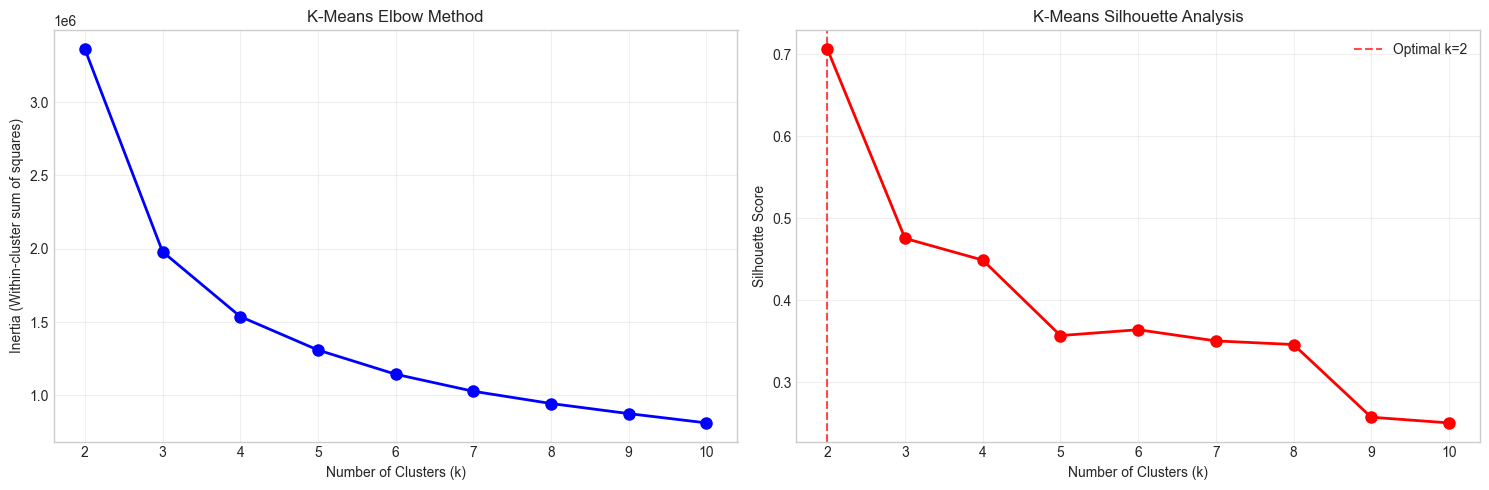


 K-Means clustering completed with k=2

 K-Means Cluster Sizes:
   Cluster 0: 744 samples (80.9%)
   Cluster 1: 176 samples (19.1%)


In [4]:
print("=== K-MEANS CLUSTERING ===\n")

if X is not None:
    # Determine optimal number of clusters using Elbow Method and Silhouette Analysis
    k_range = range(2, 11)
    inertia = []
    silhouette_scores = []
    
    print("Testing different numbers of clusters...")
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X)
        
        inertia.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, cluster_labels))
        
        print(f"   k={k}: Inertia={inertia[-1]:.2f}, Silhouette={silhouette_scores[-1]:.4f}")
    
    # Find optimal k (elbow method + silhouette)
    optimal_k_elbow = 3  # Default, we'll find the elbow
    optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
    
    print(f"\n Optimal k by silhouette: {optimal_k_silhouette}")
    
    # Plot elbow curve and silhouette scores
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Elbow curve
    ax1.plot(k_range, inertia, 'bo-', linewidth=2, markersize=8)
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Inertia (Within-cluster sum of squares)')
    ax1.set_title('K-Means Elbow Method')
    ax1.grid(True, alpha=0.3)
    
    # Silhouette scores
    ax2.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
    ax2.set_xlabel('Number of Clusters (k)')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('K-Means Silhouette Analysis')
    ax2.axvline(x=optimal_k_silhouette, color='red', linestyle='--', alpha=0.7, 
                label=f'Optimal k={optimal_k_silhouette}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Apply K-Means with optimal k
    optimal_k = optimal_k_silhouette
    kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    kmeans_labels = kmeans_final.fit_predict(X)
    
    print(f"\n K-Means clustering completed with k={optimal_k}")
    
    # Add cluster labels to visualization DataFrame
    viz_df['KMeans_Cluster'] = kmeans_labels
    
    # Calculate cluster sizes
    cluster_sizes = pd.Series(kmeans_labels).value_counts().sort_index()
    print(f"\n K-Means Cluster Sizes:")
    for cluster_id, size in cluster_sizes.items():
        print(f"   Cluster {cluster_id}: {size} samples ({size/len(X)*100:.1f}%)")
else:
    print(" No data available for K-Means clustering")

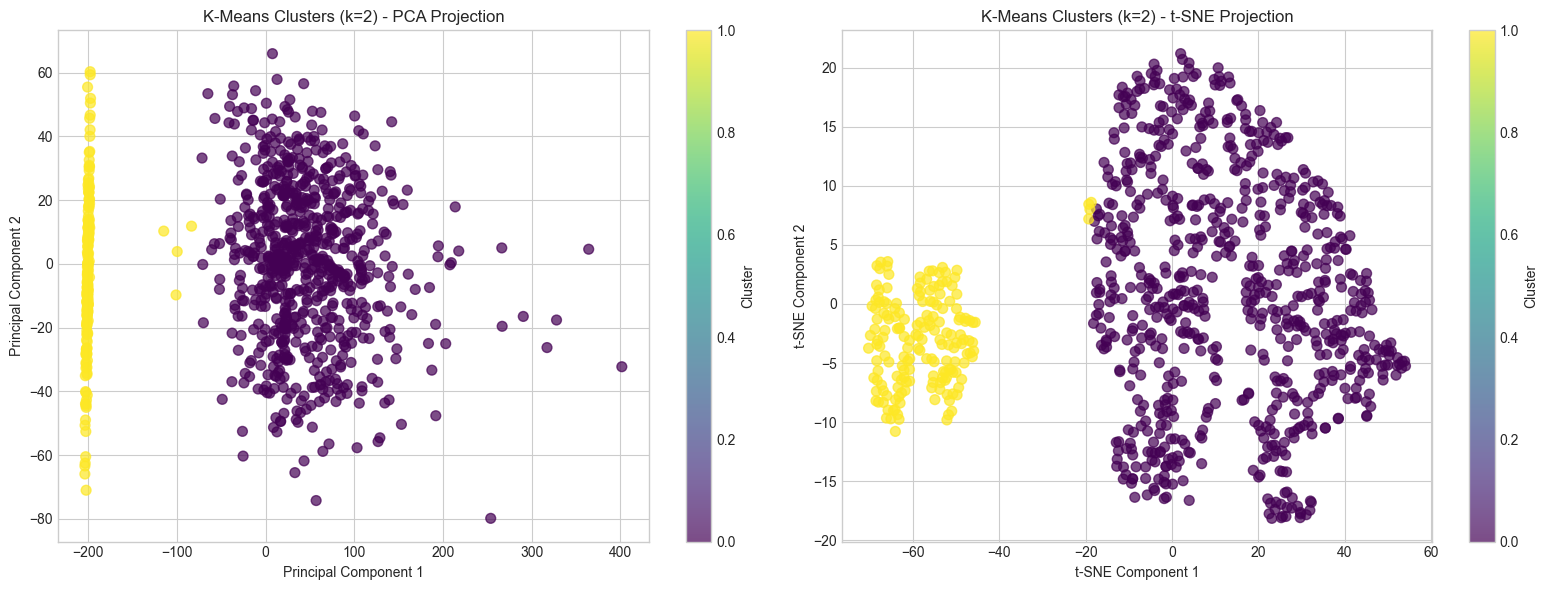

In [5]:
# Visualize K-Means Clusters
if X is not None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # PCA visualization
    scatter1 = ax1.scatter(viz_df['PCA1'], viz_df['PCA2'], c=viz_df['KMeans_Cluster'], 
                         cmap='viridis', alpha=0.7, s=50)
    ax1.set_xlabel('Principal Component 1')
    ax1.set_ylabel('Principal Component 2')
    ax1.set_title(f'K-Means Clusters (k={optimal_k}) - PCA Projection')
    plt.colorbar(scatter1, ax=ax1, label='Cluster')
    
    # t-SNE visualization
    scatter2 = ax2.scatter(viz_df['tSNE1'], viz_df['tSNE2'], c=viz_df['KMeans_Cluster'], 
                         cmap='viridis', alpha=0.7, s=50)
    ax2.set_xlabel('t-SNE Component 1')
    ax2.set_ylabel('t-SNE Component 2')
    ax2.set_title(f'K-Means Clusters (k={optimal_k}) - t-SNE Projection')
    plt.colorbar(scatter2, ax=ax2, label='Cluster')
    
    plt.tight_layout()
    plt.show()

## 5. Hierarchical Clustering

=== HIERARCHICAL CLUSTERING ===

Computing linkage matrix...


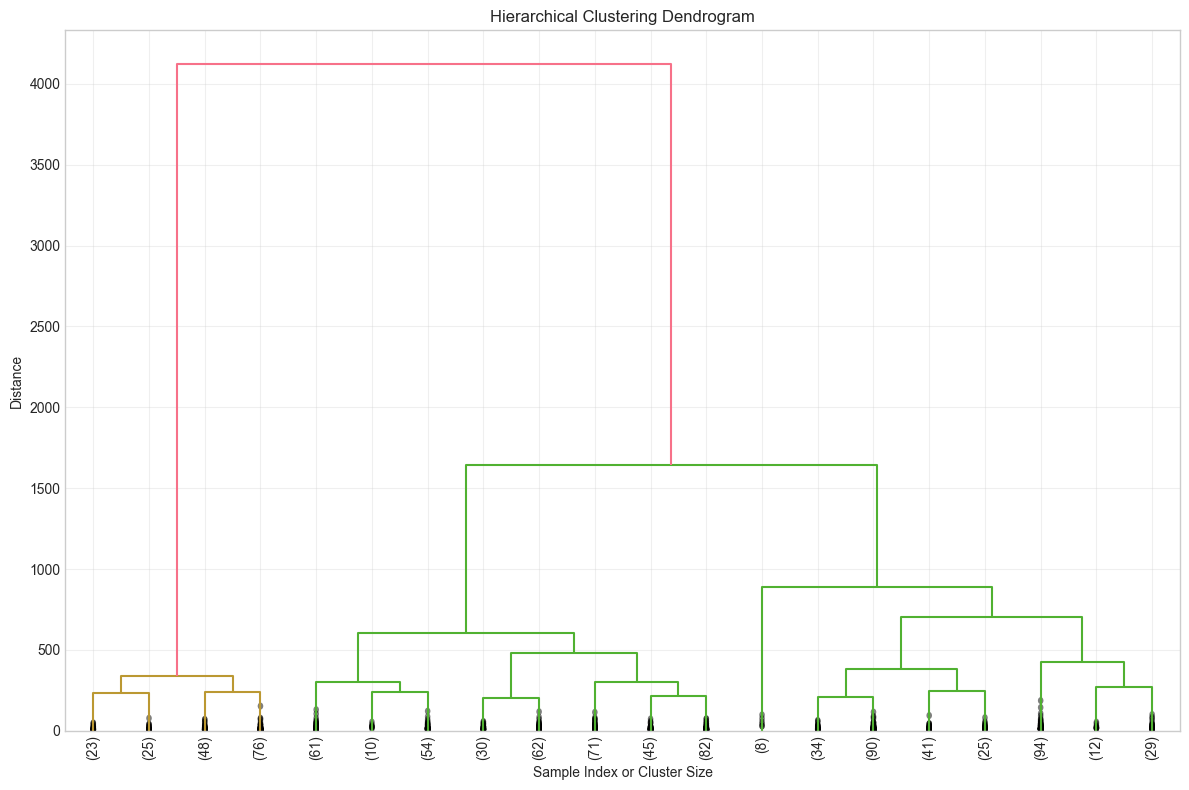

 Hierarchical clustering completed with k=2

 Hierarchical Cluster Sizes:
   Cluster 0: 748 samples (81.3%)
   Cluster 1: 172 samples (18.7%)


In [6]:
print("=== HIERARCHICAL CLUSTERING ===\n")

if X is not None:
    # Use a subset for faster computation if dataset is large
    if len(X) > 1000:
        sample_indices = np.random.choice(len(X), 1000, replace=False)
        X_sample = X.iloc[sample_indices]
        print(f"Using sampled data: {len(X_sample)} samples for hierarchical clustering")
    else:
        X_sample = X
    
    # Compute linkage matrix
    print("Computing linkage matrix...")
    linkage_matrix = linkage(X_sample, method='ward', metric='euclidean')
    
    # Plot dendrogram
    plt.figure(figsize=(12, 8))
    dendrogram(
        linkage_matrix,
        truncate_mode='lastp',
        p=20,  # Show last 20 merged clusters
        show_leaf_counts=True,
        leaf_rotation=90,
        leaf_font_size=10,
        show_contracted=True
    )
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample Index or Cluster Size')
    plt.ylabel('Distance')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Apply Agglomerative Clustering with optimal number of clusters
    # Use the same k as K-Means for comparison
    hierarchical = AgglomerativeClustering(n_clusters=optimal_k, metric='euclidean', linkage='ward')
    hierarchical_labels = hierarchical.fit_predict(X)
    
    print(f" Hierarchical clustering completed with k={optimal_k}")
    
    # Add hierarchical cluster labels to visualization DataFrame
    viz_df['Hierarchical_Cluster'] = hierarchical_labels
    
    # Calculate cluster sizes
    hierarchical_sizes = pd.Series(hierarchical_labels).value_counts().sort_index()
    print(f"\n Hierarchical Cluster Sizes:")
    for cluster_id, size in hierarchical_sizes.items():
        print(f"   Cluster {cluster_id}: {size} samples ({size/len(X)*100:.1f}%)")
else:
    print(" No data available for hierarchical clustering")

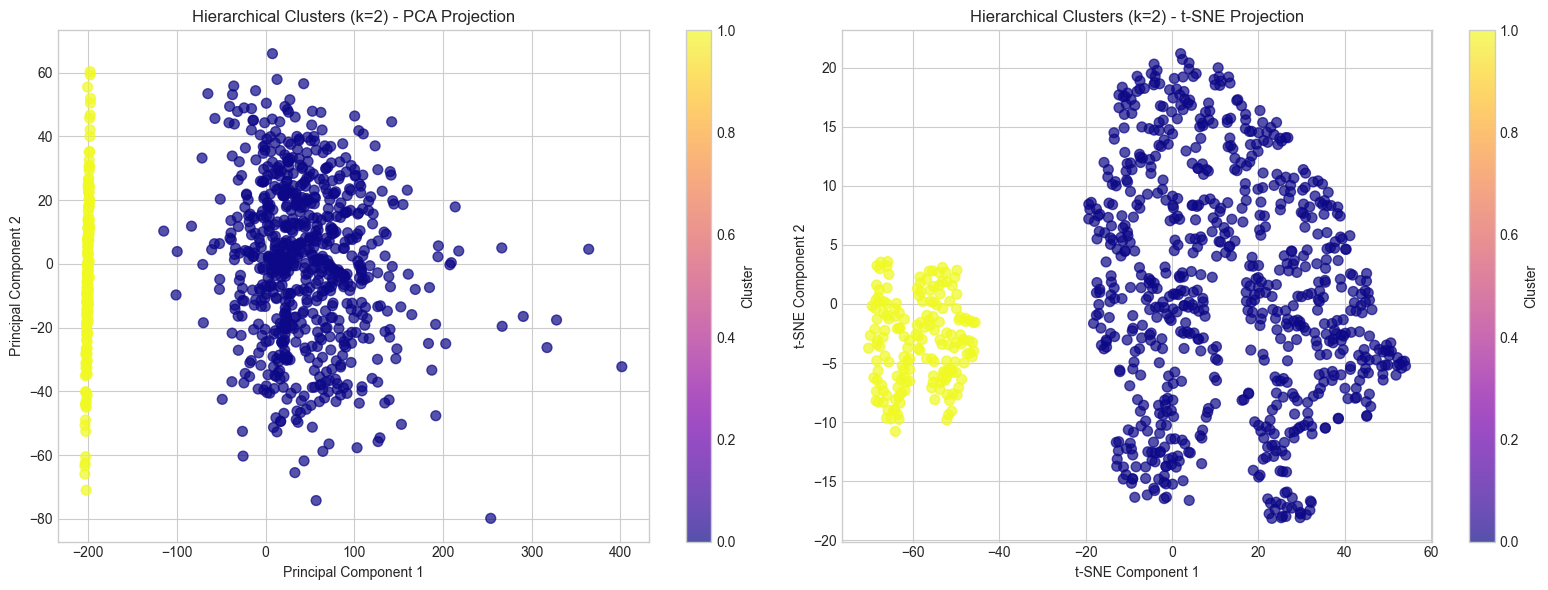

In [7]:
# Visualize Hierarchical Clusters
if X is not None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # PCA visualization
    scatter1 = ax1.scatter(viz_df['PCA1'], viz_df['PCA2'], c=viz_df['Hierarchical_Cluster'], 
                         cmap='plasma', alpha=0.7, s=50)
    ax1.set_xlabel('Principal Component 1')
    ax1.set_ylabel('Principal Component 2')
    ax1.set_title(f'Hierarchical Clusters (k={optimal_k}) - PCA Projection')
    plt.colorbar(scatter1, ax=ax1, label='Cluster')
    
    # t-SNE visualization
    scatter2 = ax2.scatter(viz_df['tSNE1'], viz_df['tSNE2'], c=viz_df['Hierarchical_Cluster'], 
                         cmap='plasma', alpha=0.7, s=50)
    ax2.set_xlabel('t-SNE Component 1')
    ax2.set_ylabel('t-SNE Component 2')
    ax2.set_title(f'Hierarchical Clusters (k={optimal_k}) - t-SNE Projection')
    plt.colorbar(scatter2, ax=ax2, label='Cluster')
    
    plt.tight_layout()
    plt.show()

## 6. Compare Clustering Results with True Labels

=== CLUSTERING vs TRUE LABELS COMPARISON ===

Clustering Performance Metrics:
----------------------------------------------------------------------
Silhouette Score          | K-Means:   0.7063 | Hierarchical:   0.7062
Calinski-Harabasz Index   | K-Means: 2334.5889 | Hierarchical: 2291.0336
Davies-Bouldin Index      | K-Means:   0.3527 | Hierarchical:   0.3453
Adjusted Rand Index       | K-Means:   0.1121 | Hierarchical:   0.1142
Normalized Mutual Info    | K-Means:   0.0699 | Hierarchical:   0.0730


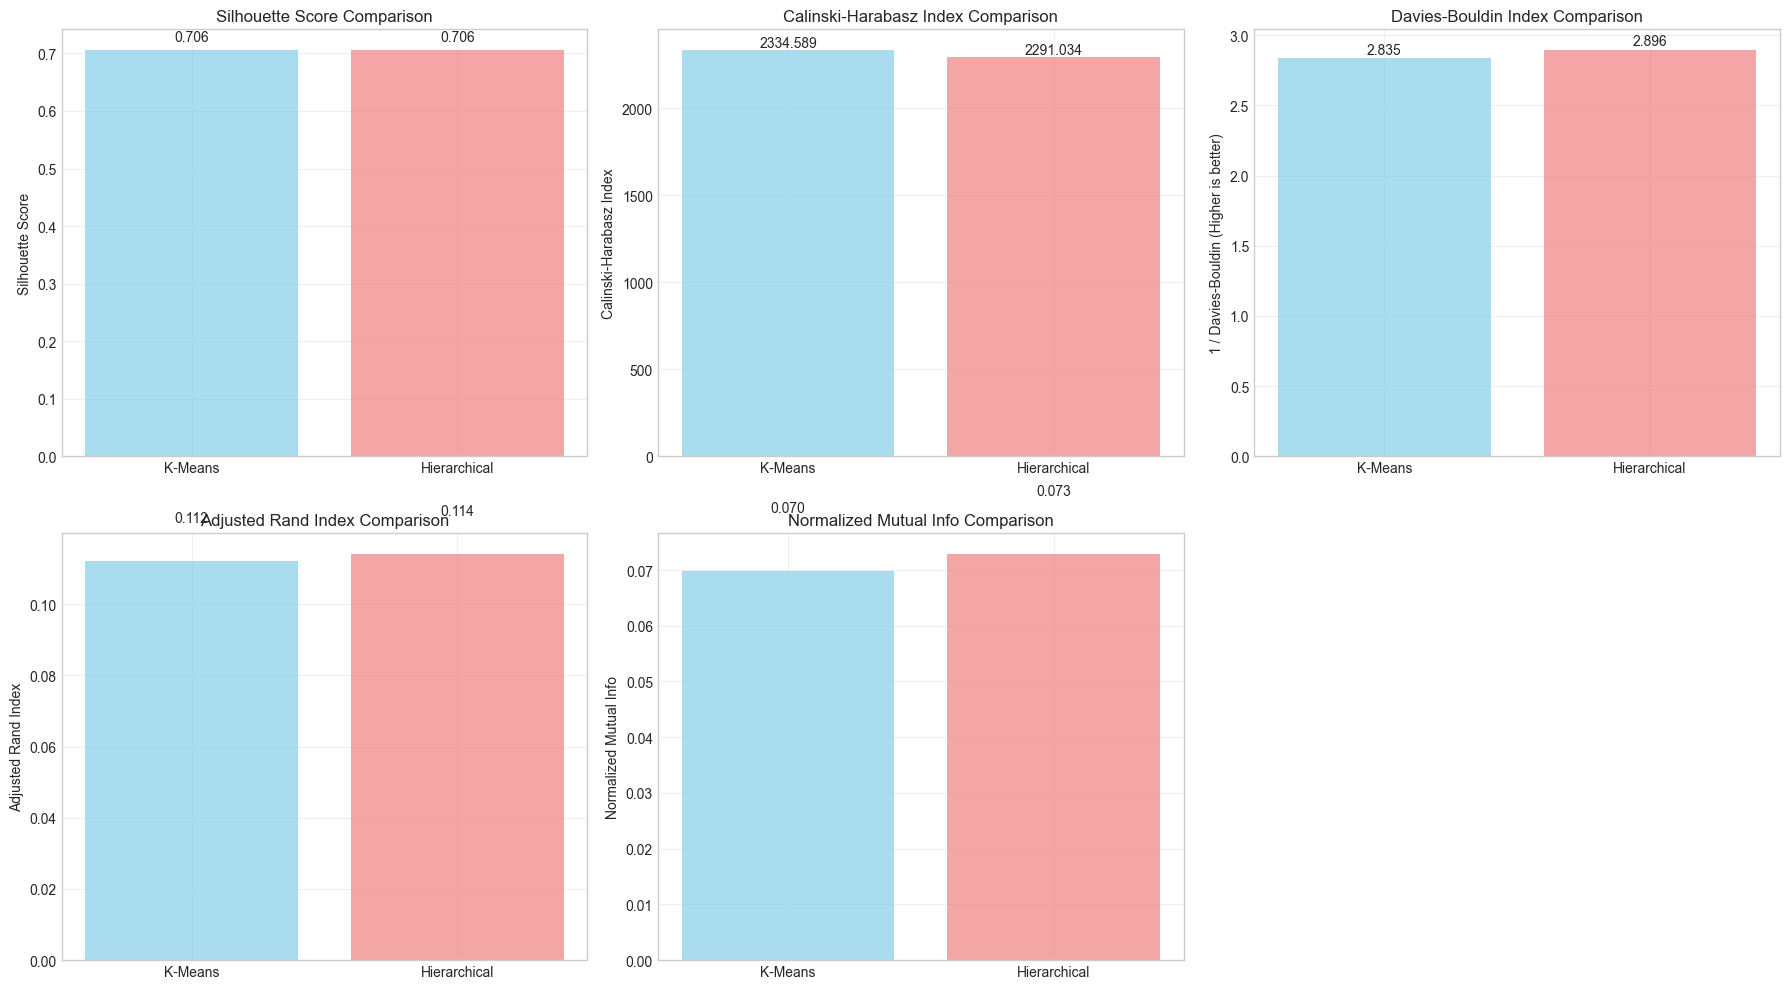


 BEST CLUSTERING METHOD: Hierarchical
   K-Means total score: 6.0580
   Hierarchical total score: 6.0804


In [8]:
print("=== CLUSTERING vs TRUE LABELS COMPARISON ===\n")

if X is not None and y_true is not None:
    # Calculate clustering metrics
    kmeans_silhouette = silhouette_score(X, kmeans_labels)
    kmeans_calinski = calinski_harabasz_score(X, kmeans_labels)
    kmeans_davies = davies_bouldin_score(X, kmeans_labels)
    
    hierarchical_silhouette = silhouette_score(X, hierarchical_labels)
    hierarchical_calinski = calinski_harabasz_score(X, hierarchical_labels)
    hierarchical_davies = davies_bouldin_score(X, hierarchical_labels)
    
    # External validation metrics (if true labels available)
    kmeans_ari = adjusted_rand_score(y_true, kmeans_labels)
    kmeans_nmi = normalized_mutual_info_score(y_true, kmeans_labels)
    
    hierarchical_ari = adjusted_rand_score(y_true, hierarchical_labels)
    hierarchical_nmi = normalized_mutual_info_score(y_true, hierarchical_labels)
    
    # Create metrics DataFrame
    metrics_df = pd.DataFrame({
        'Metric': ['Silhouette Score', 'Calinski-Harabasz Index', 'Davies-Bouldin Index', 
                  'Adjusted Rand Index', 'Normalized Mutual Info'],
        'K-Means': [kmeans_silhouette, kmeans_calinski, kmeans_davies, kmeans_ari, kmeans_nmi],
        'Hierarchical': [hierarchical_silhouette, hierarchical_calinski, hierarchical_davies, 
                       hierarchical_ari, hierarchical_nmi]
    })
    
    print("Clustering Performance Metrics:")
    print("-" * 70)
    for _, row in metrics_df.iterrows():
        print(f"{row['Metric']:25} | K-Means: {row['K-Means']:8.4f} | Hierarchical: {row['Hierarchical']:8.4f}")
    
    # Visualize metrics comparison
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()
    
    metrics_to_plot = ['Silhouette Score', 'Calinski-Harabasz Index', 'Davies-Bouldin Index', 
                      'Adjusted Rand Index', 'Normalized Mutual Info']
    
    for i, metric in enumerate(metrics_to_plot):
        metric_data = metrics_df[metrics_df['Metric'] == metric]
        
        # For Davies-Bouldin, lower is better, so we invert for consistent visualization
        if metric == 'Davies-Bouldin Index':
            values = [1/metric_data['K-Means'].iloc[0], 1/metric_data['Hierarchical'].iloc[0]]
            ylabel = '1 / Davies-Bouldin (Higher is better)'
        else:
            values = [metric_data['K-Means'].iloc[0], metric_data['Hierarchical'].iloc[0]]
            ylabel = metric
        
        bars = axes[i].bar(['K-Means', 'Hierarchical'], values, 
                         color=['skyblue', 'lightcoral'], alpha=0.7)
        axes[i].set_ylabel(ylabel)
        axes[i].set_title(f'{metric} Comparison')
        axes[i].grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, value in zip(bars, values):
            height = bar.get_height()
            axes[i].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{value:.3f}', ha='center', va='bottom')
    
    # Remove empty subplot
    fig.delaxes(axes[5])
    
    plt.tight_layout()
    plt.show()
    
    # Determine best clustering method
    kmeans_total = kmeans_silhouette + kmeans_calinski/1000 + (1/kmeans_davies) + kmeans_ari + kmeans_nmi
    hierarchical_total = hierarchical_silhouette + hierarchical_calinski/1000 + (1/hierarchical_davies) + hierarchical_ari + hierarchical_nmi
    
    best_method = "K-Means" if kmeans_total > hierarchical_total else "Hierarchical"
    
    print(f"\n BEST CLUSTERING METHOD: {best_method}")
    print(f"   K-Means total score: {kmeans_total:.4f}")
    print(f"   Hierarchical total score: {hierarchical_total:.4f}")
else:
    print(" True labels not available for comparison")

K-Means Clusters vs True Labels:
True Label         0    1   2   3   4
K-Means Cluster                      
0                389  201  63  69  22
1                 22   64  46  38   6

Hierarchical Clusters vs True Labels:
True Label              0    1   2   3   4
Hierarchical Cluster                      
0                     391  203  63  69  22
1                      20   62  46  38   6


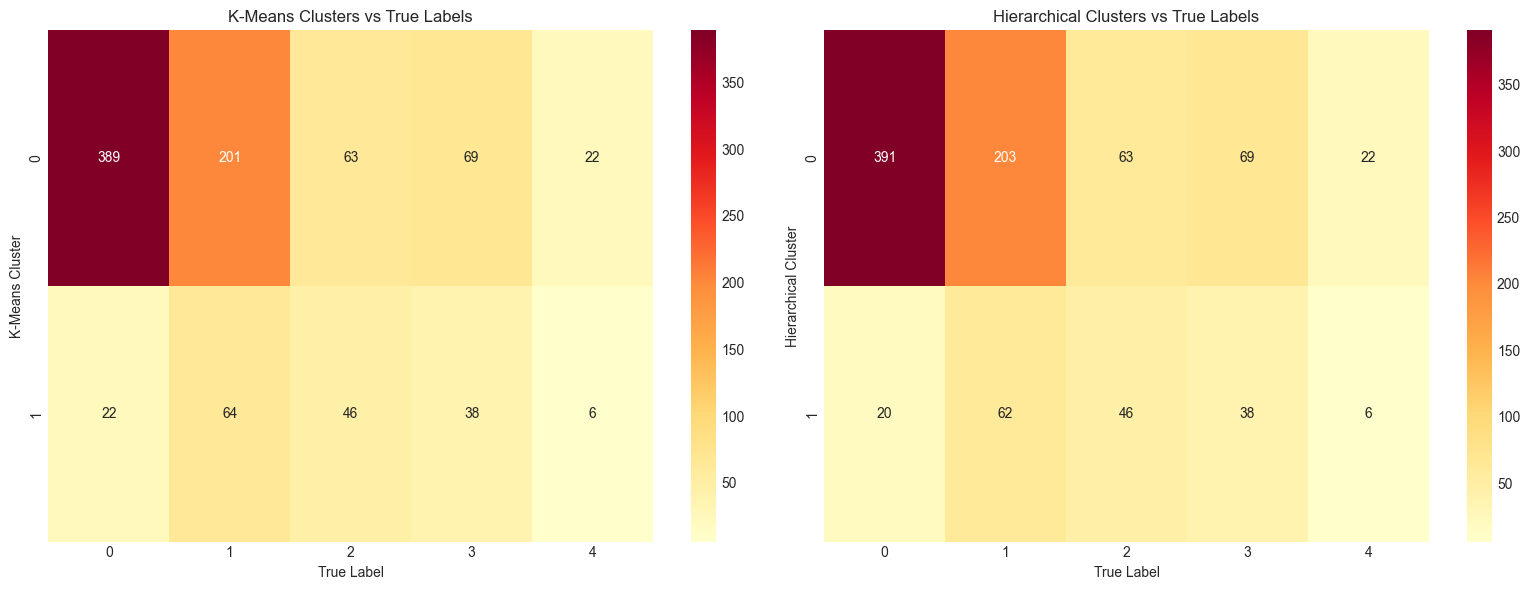

In [9]:
# Compare cluster assignments with true labels
if X is not None and y_true is not None:
    # Create cross-tabulation between clusters and true labels
    kmeans_crosstab = pd.crosstab(kmeans_labels, y_true, 
                                  rownames=['K-Means Cluster'], 
                                  colnames=['True Label'])
    
    hierarchical_crosstab = pd.crosstab(hierarchical_labels, y_true,
                                       rownames=['Hierarchical Cluster'], 
                                       colnames=['True Label'])
    
    print("K-Means Clusters vs True Labels:")
    print(kmeans_crosstab)
    print(f"\nHierarchical Clusters vs True Labels:")
    print(hierarchical_crosstab)
    
    # Visualize the correspondence
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # K-Means heatmap
    sns.heatmap(kmeans_crosstab, annot=True, fmt='d', cmap='YlOrRd', ax=ax1)
    ax1.set_title('K-Means Clusters vs True Labels')
    
    # Hierarchical heatmap
    sns.heatmap(hierarchical_crosstab, annot=True, fmt='d', cmap='YlOrRd', ax=ax2)
    ax2.set_title('Hierarchical Clusters vs True Labels')
    
    plt.tight_layout()
    plt.show()

## 7. Cluster Profiling and Interpretation

=== CLUSTER PROFILING ===

K-MEANS CLUSTER PROFILES:
--------------------------------------------------

Cluster 0 (n=744):
  Most distinctive features:
    - chol: 246.659 (diff: 244.375)
    - thalach: 141.073 (diff: 17.669)
    - trestbps: 132.634 (diff: 3.339)

Cluster 1 (n=176):
  Most distinctive features:
    - chol: 2.284 (diff: 244.375)
    - thalach: 123.403 (diff: 17.669)
    - trestbps: 129.295 (diff: 3.339)


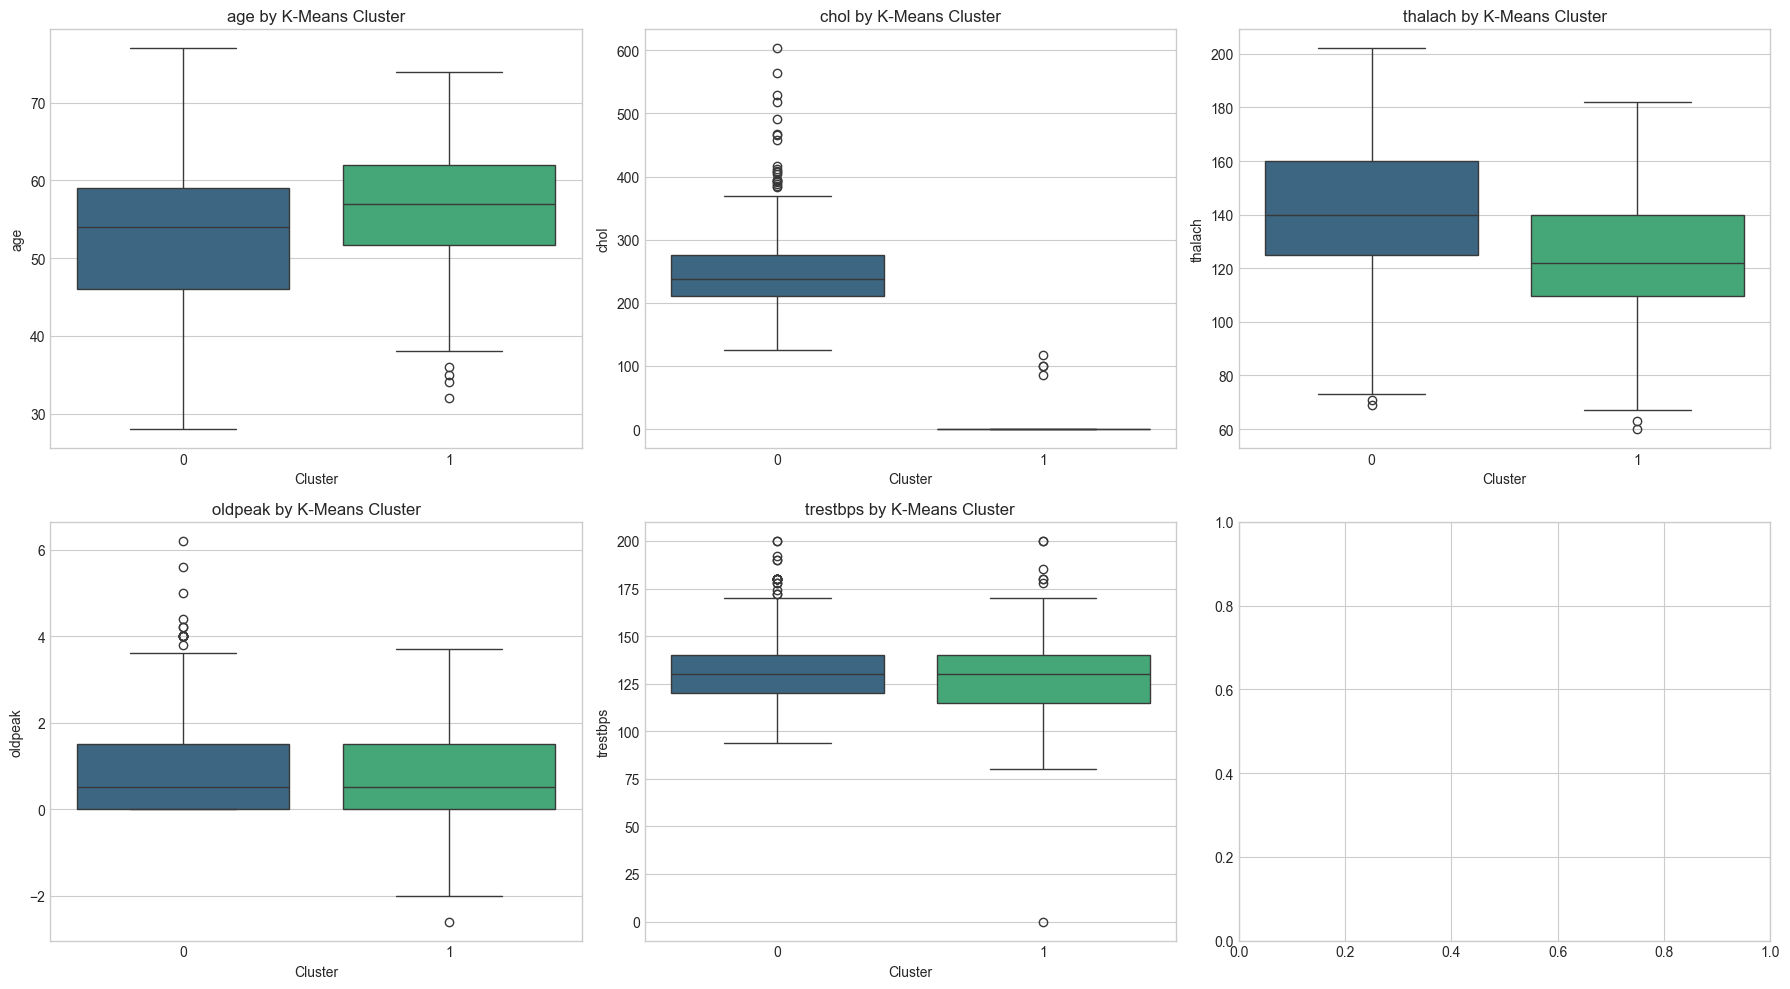

In [10]:
print("=== CLUSTER PROFILING ===\n")

if X is not None:
    # Add cluster labels to original data for profiling
    profiling_df = X.copy()
    profiling_df['KMeans_Cluster'] = kmeans_labels
    profiling_df['Hierarchical_Cluster'] = hierarchical_labels
    
    if y_true is not None:
        profiling_df['True_Label'] = y_true.values
    
    # Analyze K-Means clusters
    print("K-MEANS CLUSTER PROFILES:")
    print("-" * 50)
    
    kmeans_profile = profiling_df.groupby('KMeans_Cluster').mean()
    
    # Display top 3 most distinctive features per cluster
    for cluster_id in sorted(profiling_df['KMeans_Cluster'].unique()):
        cluster_data = profiling_df[profiling_df['KMeans_Cluster'] == cluster_id]
        other_data = profiling_df[profiling_df['KMeans_Cluster'] != cluster_id]
        
        # Find features that differ most from other clusters
        feature_differences = {}
        for feature in X.columns:
            cluster_mean = cluster_data[feature].mean()
            other_mean = other_data[feature].mean()
            feature_differences[feature] = abs(cluster_mean - other_mean)
        
        # Get top 3 most distinctive features
        top_features = sorted(feature_differences.items(), key=lambda x: x[1], reverse=True)[:3]
        
        print(f"\nCluster {cluster_id} (n={len(cluster_data)}):")
        print(f"  Most distinctive features:")
        for feature, difference in top_features:
            cluster_mean = cluster_data[feature].mean()
            print(f"    - {feature}: {cluster_mean:.3f} (diff: {difference:.3f})")
    
    # Visualize cluster characteristics
    important_features = ['age', 'chol', 'thalach', 'oldpeak', 'trestbps']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()
    
    for i, feature in enumerate(important_features[:6]):
        if feature in X.columns:
            # K-Means boxplot
            sns.boxplot(data=profiling_df, x='KMeans_Cluster', y=feature, ax=axes[i], palette='viridis')
            axes[i].set_title(f'{feature} by K-Means Cluster')
            axes[i].set_xlabel('Cluster')
            axes[i].set_ylabel(feature)
    
    plt.tight_layout()
    plt.show()

## 8. Save Clustering Results

In [11]:
print("=== SAVING CLUSTERING RESULTS ===\n")

if X is not None:
    # Save clustering results
    clustering_results = pd.DataFrame({
        'KMeans_Cluster': kmeans_labels,
        'Hierarchical_Cluster': hierarchical_labels
    })
    
    if y_true is not None:
        clustering_results['True_Label'] = y_true.values
    
    clustering_results.to_csv('../results/clustering_assignments.csv', index=False)
    
    # Save visualization data
    viz_df.to_csv('../results/clustering_visualization_data.csv', index=False)
    
    # Save clustering models
    import joblib
    joblib.dump(kmeans_final, '../models/kmeans_model.pkl')
    joblib.dump(hierarchical, '../models/hierarchical_model.pkl')
    
    # Save metrics
    metrics_df.to_csv('../results/clustering_metrics.csv', index=False)
    
    print(" Clustering results saved successfully!")
    print("   - clustering_assignments.csv: Cluster labels for all samples")
    print("   - clustering_visualization_data.csv: PCA and t-SNE coordinates")
    print("   - kmeans_model.pkl: Trained K-Means model")
    print("   - hierarchical_model.pkl: Trained Hierarchical model")
    print("   - clustering_metrics.csv: Performance metrics")
    
    print(f"\n Clustering Summary:")
    print(f"   Optimal clusters: {optimal_k}")
    print(f"   Best method: {best_method}")
    print(f"   K-Means silhouette: {kmeans_silhouette:.4f}")
    print(f"   Hierarchical silhouette: {hierarchical_silhouette:.4f}")
    
    if y_true is not None:
        print(f"   Agreement with true labels (ARI): {max(kmeans_ari, hierarchical_ari):.4f}")
    
    
else:
    print(" No clustering results to save")

=== SAVING CLUSTERING RESULTS ===

 Clustering results saved successfully!
   - clustering_assignments.csv: Cluster labels for all samples
   - clustering_visualization_data.csv: PCA and t-SNE coordinates
   - kmeans_model.pkl: Trained K-Means model
   - hierarchical_model.pkl: Trained Hierarchical model
   - clustering_metrics.csv: Performance metrics

 Clustering Summary:
   Optimal clusters: 2
   Best method: Hierarchical
   K-Means silhouette: 0.7063
   Hierarchical silhouette: 0.7062
   Agreement with true labels (ARI): 0.1142
